In [2]:
import math as m
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from imp import reload
#from IPython.parallel import Client
%matplotlib inline


## Antennas in an array

In [3]:
import AntennaArray
import Signal
import Beamformer
import SetOfBeamformers
reload(AntennaArray)
reload(Signal)
reload(Beamformer)
reload(SetOfBeamformers)

from AntennaArray import AntennaArray
from Signal import Signal
from Beamformer import Beamformer
from SetOfBeamformers import SetOfBeamformers

### Positions of 30 antennas in a an array with radius 5cm

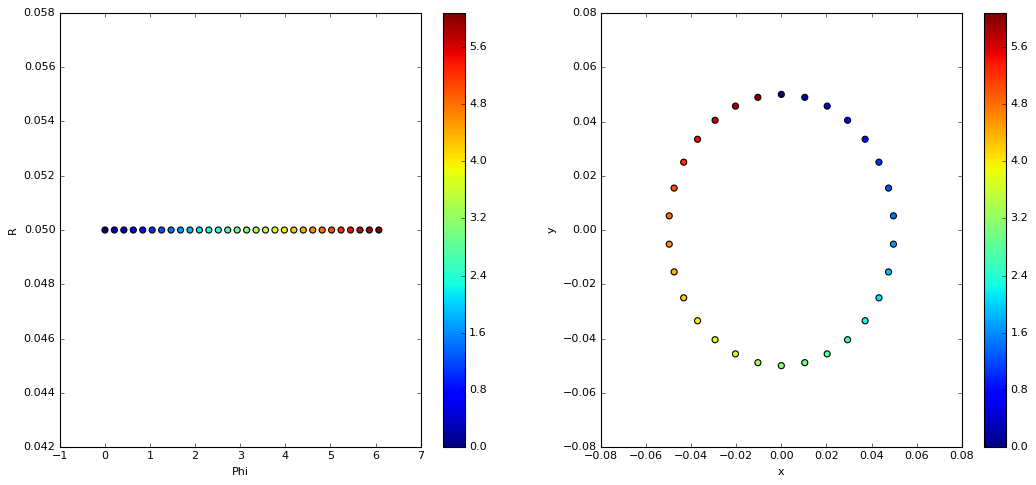

In [4]:
R = 0.05
NAntennas = 30

Array = AntennaArray(R, NAntennas)

fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(Array.positions.T[1], Array.positions.T[0], s=30, c = Array.positions.T[1])
plt.xlabel('Phi')
plt.ylabel('R')
plt.colorbar()

plt.subplot(122)
plt.scatter(Array.positions_xy.T[0], Array.positions_xy.T[1], s=30, c = Array.positions.T[1])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

## Signal

('SR: ', 999.90000000000009, 'GHz')


/home/chrischtel/.local/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


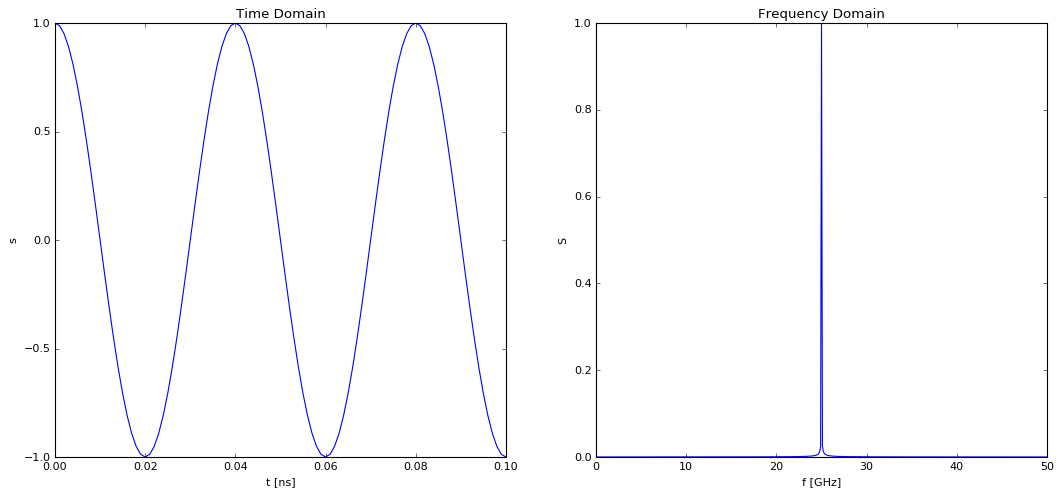

In [5]:
NBins = 10**4
t = np.linspace(0.0, 10**-8, NBins)
print('SR: ',1/(t[1]-t[0])*10**-9, 'GHz')


# Create a signal with 25GHz and plot time and frequency domain
S0 = Signal(1.0, 25.0*10**9, 0.04, 0.0, 0)
S0Signal = S0.TimeDomainSignal(t)
S0SignalFreq = S0.FreqDomainSignal(t)

def plot_signal():
    fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.plot(t*10**9, S0Signal)
    plt.xlabel('t [ns]')
    plt.ylabel('s')
    plt.xlim([0, 0.1])
    plt.title('Time Domain')

    plt.subplot(122)
    plt.plot(S0SignalFreq[0]*10**-9, np.abs(S0SignalFreq[1]))
    plt.xlabel('f [GHz]')
    plt.ylabel('S')
    plt.title('Frequency Domain')
    plt.xlim([0, 50])
plot_signal()


## Delay at antennas in array

('Sampling rate for time delay: ', 3.3333333333333335, 'GHz')


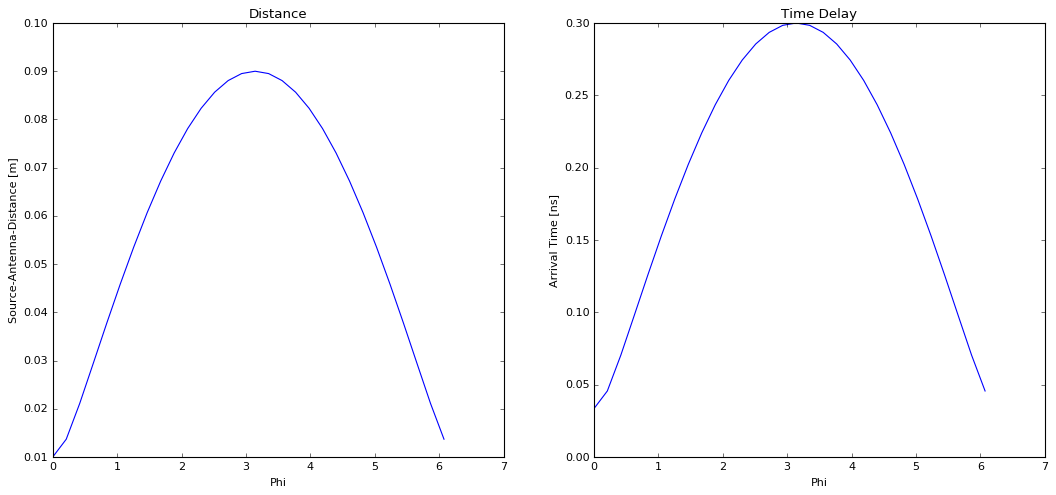

In [6]:


def distance(r1, phi1, r2, phi2):
    return np.sqrt(r1**2+r2**2-2*r1*r2*np.cos(phi1-phi2))

def time_delay(r1, phi1, r2, phi2):
    c0 = 3.0*10**8
    d = distance(r1, phi1, r2, phi2)
    return d/c0

signal_distance = distance(Array.positions.T[0], Array.positions.T[1], S0.position[0], S0.position[1])
signal_delay = time_delay(Array.positions.T[0], Array.positions.T[1], S0.position[0], S0.position[1])

fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(Array.positions.T[1], signal_distance)
plt.xlabel('Phi')
plt.ylabel('Source-Antenna-Distance [m]')
plt.title('Distance')

plt.subplot(122)
plt.plot(Array.positions.T[1], signal_delay*10**9)
plt.xlabel('Phi')
plt.ylabel('Arrival Time [ns]')
plt.title('Time Delay')
print('Sampling rate for time delay: ', 1/np.max(signal_delay)*10**-9, 'GHz')



## Signal seen by perfect antennas

#### Transfer of time shift in original signal to phase shift in mixed down signal
- $\cos(\phi_1)\cdot \cos(\phi_2)=\frac{1}{2}\cdot(\cos(\phi_1+\phi_2)+\cos(\phi_1-\phi_2))$
- $\phi_1=\omega_1 (t - t_0) = \omega_1 \cdot t -\omega_1\cdot t_0,\: \: \phi_2 = \omega_2 t$
- $\phi_1-\phi_2 = (\omega_1-\omega_2)\cdot t - \omega_1 \cdot t_0$

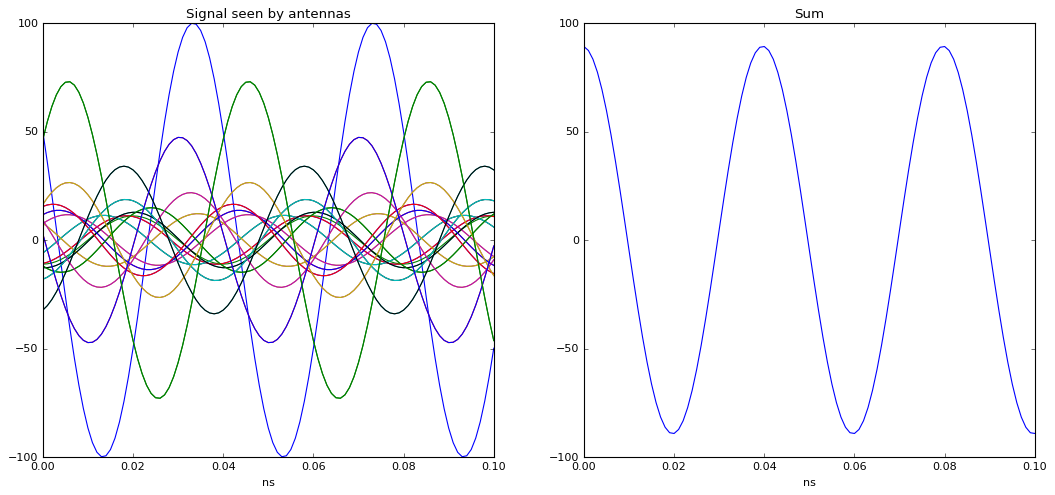

In [7]:


# Signal
#t = np.linspace(0.0, 10**-8, 10**4)
S0 = Signal(1.0, 25.0*10**9, 0.04, 0.0, 0)

fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
SummedSignal = np.zeros(np.shape(Array.Antennas[0].ReceiveSignalBeforeMixDown(S0, t)))*(1+1j*1)
# plot signal seen by all antennas
for i in range(NAntennas):
    SummedSignal+=Array.Antennas[i].ReceiveSignalBeforeMixDown(S0, t)
    plt.plot(t*10**9, Array.Antennas[i].ReceiveSignalBeforeMixDown(S0, t))#, t*10**9, Array.antennas[15].ReceivedSignalAfterMixDown(S0))
plt.xlim([0, 0.1])
plt.xlabel('ns')
#plt.ylim([-100, 100])
plt.title('Signal seen by antennas')

plt.subplot(122)
plt.plot(t*10**9, SummedSignal)
plt.xlim([0.0, 0.1])
plt.xlabel('ns')
plt.title('Sum')
#plt.ylim([-100, 100])

## Mix down received signal

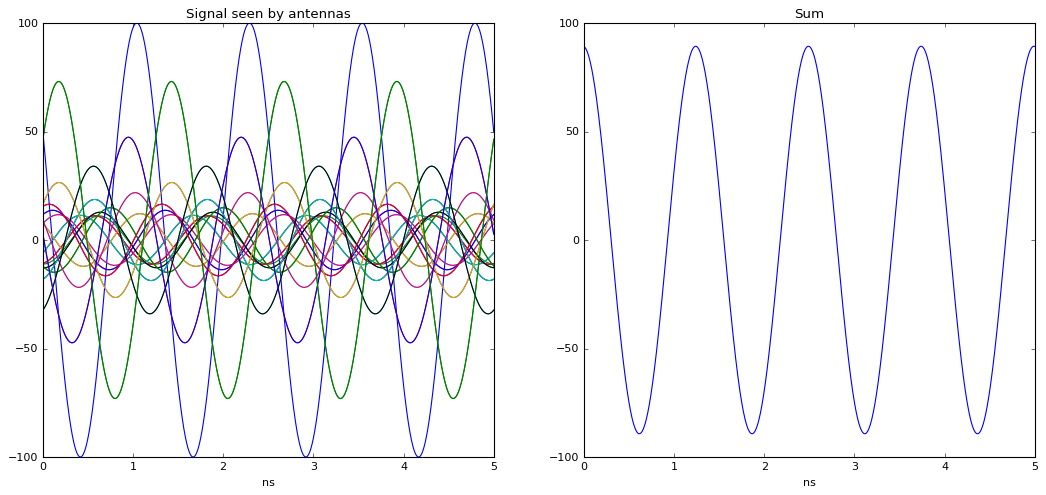

In [8]:
# Signal
#t = np.linspace(0.0, 10**-4, 10**4)
S0 = Signal(1.0, 25.0*10**9, 0.04, 0.0, 0)
fMix = 24.2e9


fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
SummedSignal = np.zeros(np.shape(t))*(1+1j*1)
# plot signal seen by all antennas
for i in range(NAntennas):
    Array.Antennas[i].ReceiveSignalBeforeMixDown(S0, t)
    SummedSignal+=Array.Antennas[i].MixdownReceivedSignal(fMix, t)
    plt.plot(t*10**9, Array.Antennas[i].MixdownReceivedSignal(fMix, t))
plt.xlim([0, 5])
plt.xlabel('ns')
#plt.ylim([-100, 100])
plt.title('Signal seen by antennas')

plt.subplot(122)
plt.plot(t*10**9, SummedSignal)
plt.xlim([0.0, 5])
plt.xlabel('ns')
plt.title('Sum')
#plt.ylim([-100, 100])

## Beamforming via phase shifting for constant frequency

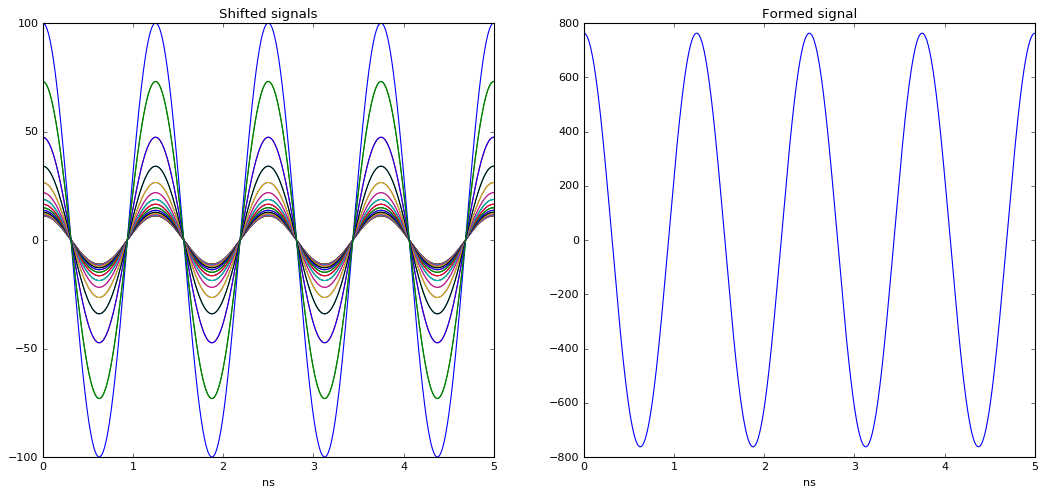

In [9]:
def Weights(f, time_shift, fMix):
    return np.exp(1j*2.0*np.pi*(f+fMix)*time_shift)

# Signal
S0 = Signal(1.0, 25.0e9, 0.04, 0.0, 0)
fMix = 24.2e9

fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
SummedSignal = np.copy(Array.Antennas[0].ReceiveSignalBeforeMixDown(S0, t))*0.0

for i in range(NAntennas):
    
    time_shift = Array.Antennas[i].TimeDelay(S0)
    Array.Antennas[i].ReceiveSignalBeforeMixDown(S0, t)
    SummedSignal+=Array.Antennas[i].MixdownReceivedSignal(fMix, t)*Weights(800e6, time_shift, fMix)
    plt.plot(t*10**9, Array.Antennas[i].MixdownReceivedSignal(fMix, t)*Weights(800e6, time_shift, fMix))#, t*10**9, Array.antennas[15].ReceivedSignalAfterMixDown(S0)*Weights(S0.mixfreq, time_shift2))
plt.xlim([0, 5])
plt.xlabel('ns')
plt.title('Shifted signals')

plt.subplot(122)
plt.plot(t*10**9, SummedSignal)
plt.xlim([0.0, 5])
plt.xlabel('ns')
plt.title('Formed signal')




## Weights for range of frequencies

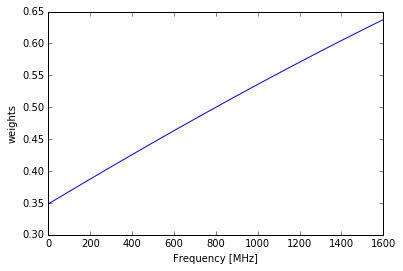

In [10]:
frequencies = np.linspace(0,1.6*10**9, 10000)
fMix = 24.2e9
freq_weights = Weights(frequencies, Array.Antennas[0].TimeDelay(S0), fMix)

plt.plot(frequencies*10**-6, freq_weights)
plt.xlabel('Frequency [MHz]')
plt.ylabel('weights')


## Digitize

slice length: 1.28e-06
3.125e-10


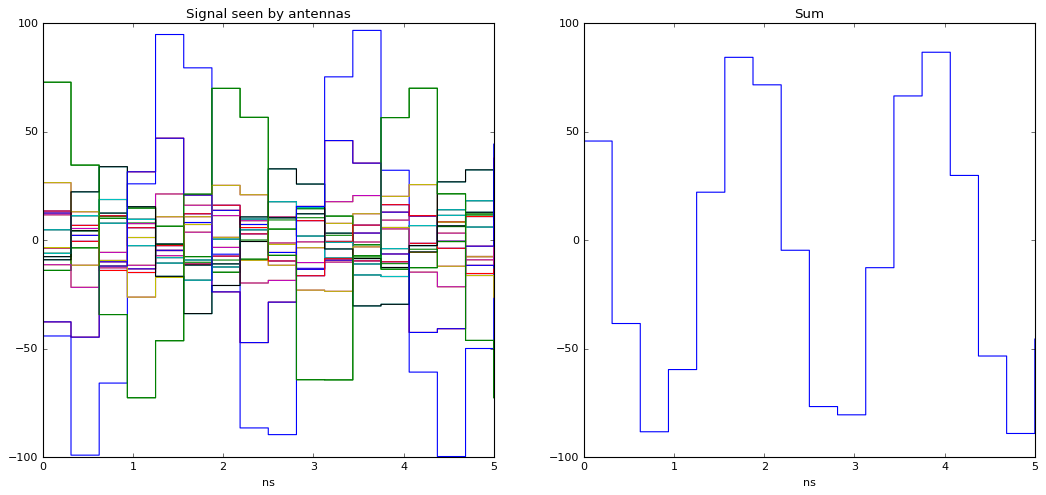

In [11]:
# Signal
#t = np.linspace(0.0, 10**-4, 10**4)
#S0 = Signal(1.0, 25.0*10**9, 0.04, 0.0, 0)
fMix = 24.5e9
sampling_rate = 3.2e9
tmax = 4096*1/sampling_rate
print('slice length: {}'.format(tmax))
t_sampled = np.arange(0, tmax, 1/sampling_rate)
print(1/(3.2e9))



fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
SummedSignal = np.zeros(np.shape(t_sampled))*(1+1j*1)
# plot signal seen by all antennas
for i in range(NAntennas):
    Array.Antennas[i].ReceiveSignalBeforeMixDown(S0, t)
    SummedSignal+=Array.Antennas[i].MixAndDigitizeSignal(fMix, tmax, sampling_rate)[1]
    t_sampled, signal_sampled =  Array.Antennas[i].MixAndDigitizeSignal(fMix, tmax, sampling_rate)
    plt.step(t_sampled*10**9, signal_sampled)
plt.xlim([0, 5])
plt.xlabel('ns')
#plt.ylim([-100, 100])
plt.title('Signal seen by antennas')

plt.subplot(122)
plt.step(t_sampled*10**9, SummedSignal)
plt.xlim([0.0, 5])
plt.xlabel('ns')
plt.title('Sum')
#plt.ylim([-100, 100])




## Phase shift sampled mixed signals

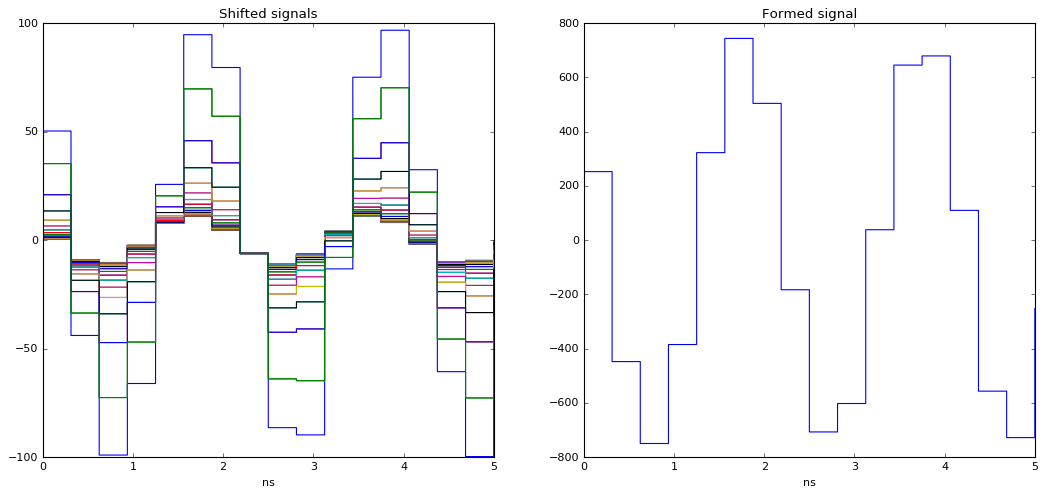

In [12]:
def Weights(f, time_shift, fMix):
    return np.exp(1j*2.0*np.pi*(f+fMix)*time_shift)

# Signal
S0 = Signal(1.0, 25.0e9, 0.04, 0.0, 0)
fMix = 24.5e9

fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
SummedSignal = np.zeros(np.shape(t_sampled))*(1+1j)

for i in range(NAntennas):
    
    time_shift = Array.Antennas[i].TimeDelay(S0)
    Array.Antennas[i].ReceiveSignalBeforeMixDown(S0, t)
    SummedSignal+=Array.Antennas[i].MixAndDigitizeSignal(fMix, tmax, sampling_rate)[1]*Weights(800e6, time_shift, fMix)
    plt.step(t_sampled*10**9, Array.Antennas[i].MixAndDigitizeSignal(fMix, tmax, sampling_rate)[1]*Weights(800e6, time_shift, fMix))#, t*10**9, Array.antennas[15].ReceivedSignalAfterMixDown(S0)*Weights(S0.mixfreq, time_shift2))
plt.xlim([0, 5])
plt.xlabel('ns')
plt.title('Shifted signals')

plt.subplot(122)
plt.step(t_sampled*10**9, SummedSignal)
plt.xlim([0.0,5])
plt.xlabel('ns')
plt.title('Formed signal')




## Single Beamformer

4096.0


Beamformer.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  self.wspectrum[i] = self.fspectrum*self.weights[i]
Beamformer.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  self.wsignal[i]=np.fft.ifft(self.wspectrum[i])


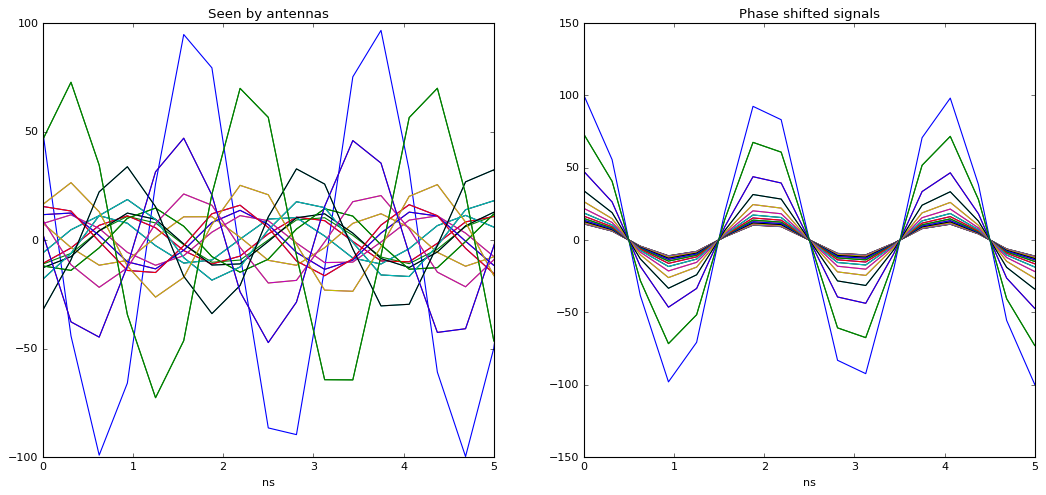

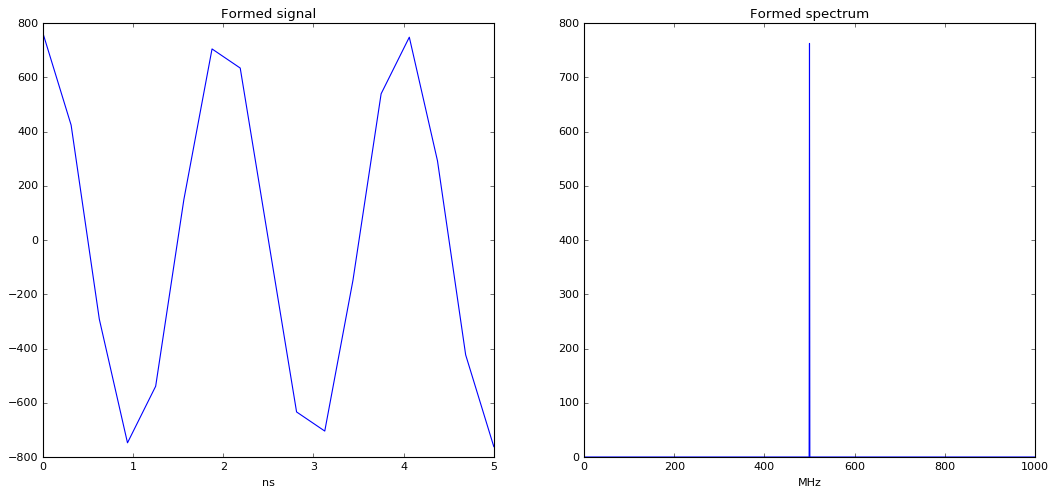

In [13]:
print(tmax*sampling_rate)
B1 = Beamformer(0.04, 0, Array, fMix, sampling_rate, tmax)

S0 = Signal(1.0, 25.0*10**9, 0.04, 0.0, 0.0)

ShiftedSignals, FormedSignal, FormedSpectrum  = B1.PhaseShift(Array.ReceiveSignals([S0], t, fMix, sampling_rate, tmax))

B1.Plotter()



(30, 4096)


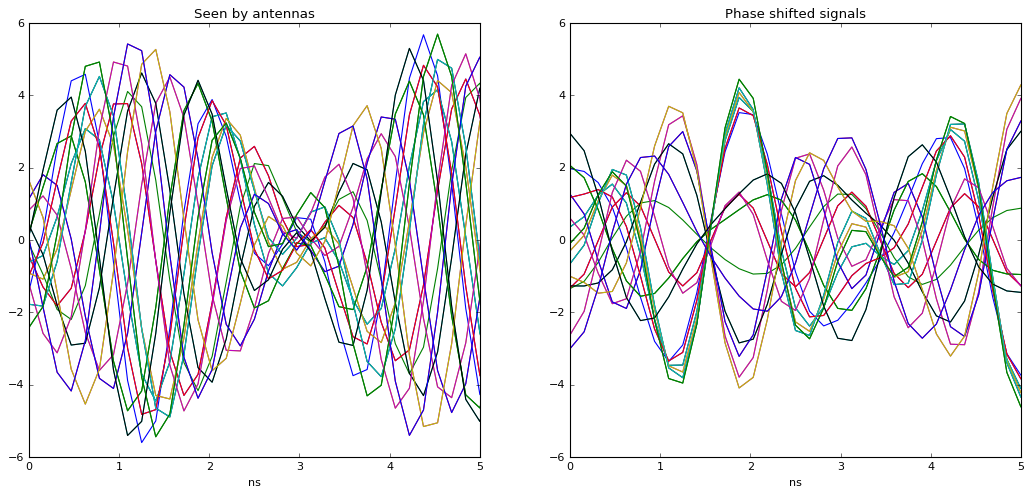

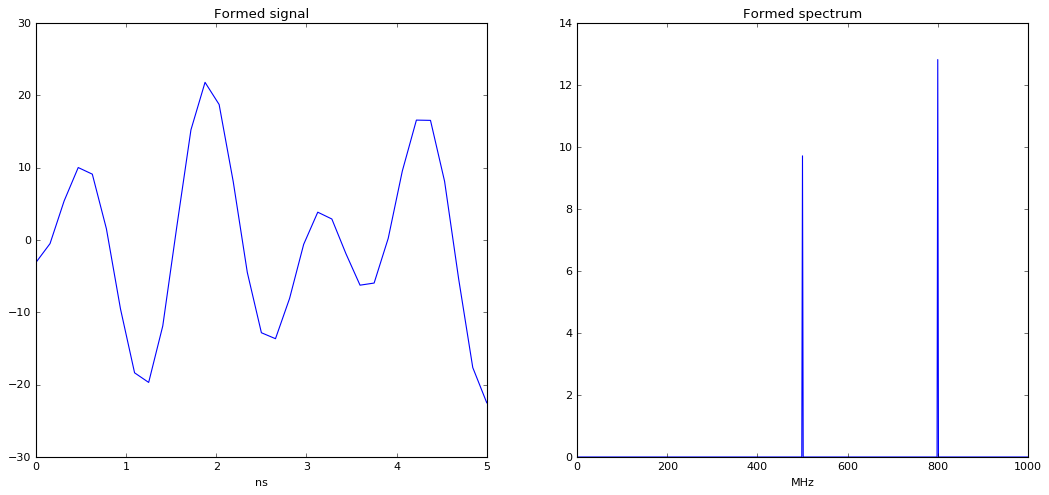

In [14]:
# test with sum of signals

S0 = Signal(1.0, 25.0*10**9, 0.4, 0.0, 0)
S1 = Signal(1.0, 25.3*10**9, 0.4, 0.0, 0)
sampling_rate = 6.4e9
tmax = 4096*1/sampling_rate

# Create Beamformer
B2 = Beamformer(0.0, 0, Array, fMix, sampling_rate, tmax)

# Receive signals
received_signal = Array.ReceiveSignals([S0, S1], t, fMix, sampling_rate, tmax)
print(np.shape(received_signal))
# Give it list of signals

ShiftedSignals, FormedSignal, FormedSpectrum = B2.PhaseShift(received_signal)
# let it plot
B2.Plotter()


## Set of Beamformers

Initializing beamformers...
... took 0.445 s
Got 37 beamformers.


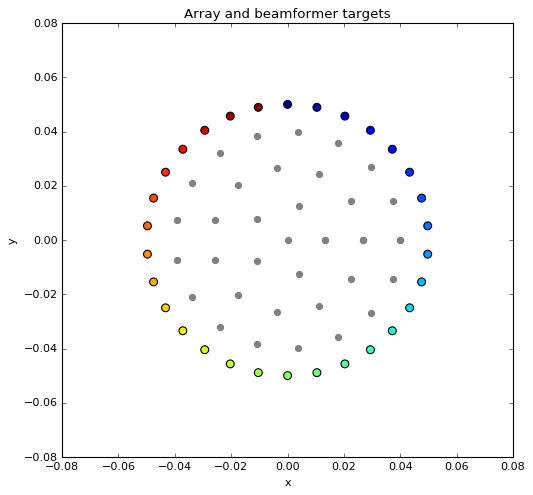

In [15]:
import SetOfBeamformers
reload(SetOfBeamformers)
from SetOfBeamformers import *

nr = 4
nphi = 6

Set0 = SetOfBeamformers(nr, nphi, Array, fMix, sampling_rate, tmax)
Set0.Plotter()


## Find Beamformer with highest overall amplitdue

Distributing signal among beamformers...
... took 0.299 s.
Beamfomer 10 looking at [r, phi/spi] = 0.0266666666667, 0.273 has strongest signal.
The frequency of that signal is 300.0 MHz.


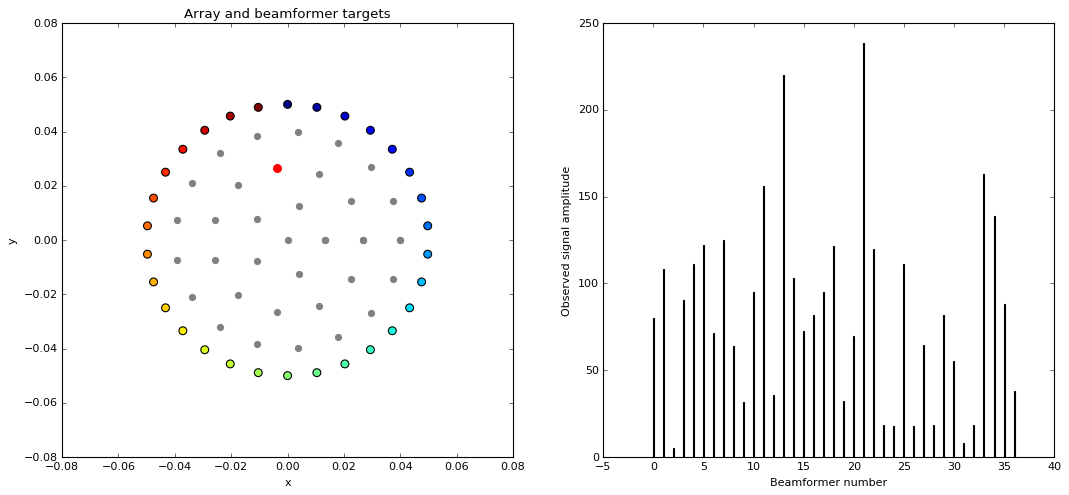

In [16]:
# signals
S0 = Signal(1.0, 24.8*10**9, 0.02, m.pi/2, 0)



# go
ReceivedSignals = Array.ReceiveSignals([S0], t, fMix, sampling_rate, tmax)
Set0.DistributeSignal(ReceivedSignals)
Set0.CollectAbsoluteMaxima()




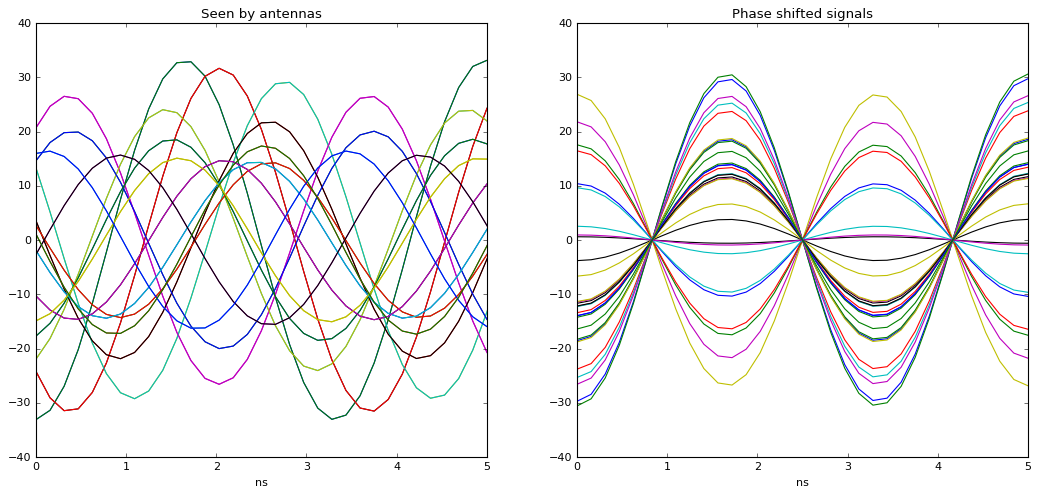

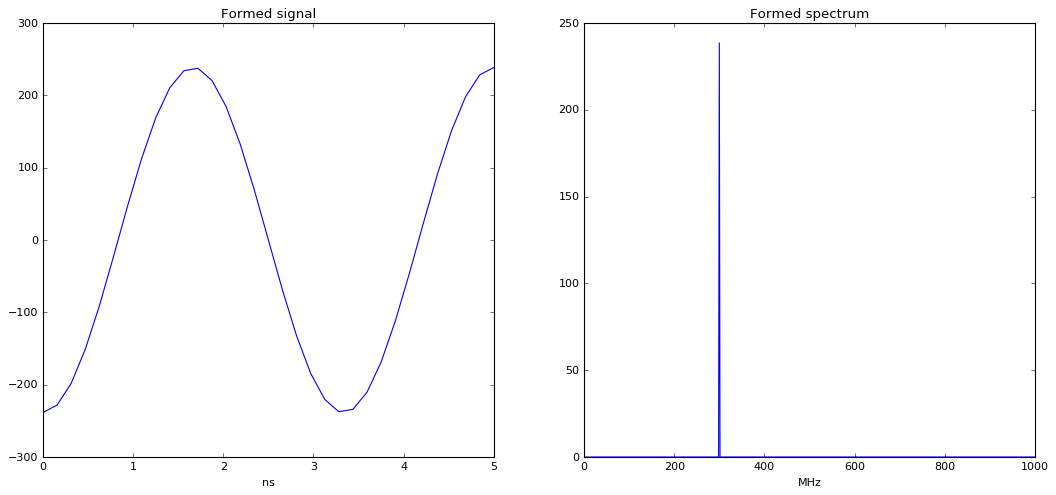

In [17]:
Set0.Beamformers['10'].Plotter()


## Plot map of amplitude vs fequency bin and beamformer

## Magnitude Plot

In [46]:


        
def Magnitude(self, freqlimits):
        Z = np.zeros(self.Nbeamformers+1)
        r = np.copy(Z)
        phi = np.copy(Z)
        
        iBins = np.where((self.FormedSpectrum['0'][0]>freqlimits[0]) & (self.FormedSpectrum['0'][0]<=freqlimits[1]))
        #print(freqlimits, np.shape(iBins), np.shape(self.FormedSpectrum['0'][0]))
        
        for i in self.Beamformers.keys():   
            # for surf plot
            r[int(i)], phi[int(i)] = self.Beamformers[i].r, self.Beamformers[i].phi
            Z[int(i)] = np.max(np.abs(self.FormedSpectrum[i][1][iBins]))
            
        return r, phi, Z
        
        
def MagnitudePlot(r, phi, Z, n, frange):
    
    Z_interp = interpolate.Rbf(np.array(r*np.cos(phi)), np.array(r*np.sin(phi)), (Z), function='linear')
    x = np.linspace(-0.05, 0.05, n)
    y = np.linspace(-0.05, 0.05, n)
    X, Y = np.meshgrid(x, y)
    Z = Z_interp(X, Y)
    Z[X**2+Y**2>0.04**2] = "nan"
    plt.subplot(122)
    plt.title('Interpolated magnitudes in frequency range {}MHz - {}MHz'.format(np.int(frange[0]*1e-6), np.int(frange[1]*1e-6)))
    plt.contourf(X, Y, np.log10(Z), 50)
    plt.colorbar()
    plt.clim(1,3)
    plt.xlim([-0.05, 0.05])
    plt.ylim([-0.05, 0.05])
    plt.savefig('beamforming.png')
   

#SetOfBeamformers.Plotter = Plotter
SetOfBeamformers.Magnitude=Magnitude



In [48]:
fMix = 24.5e9
sampling_rate = 3.2e9
number_of_samples = 4096
tmax = 1/sampling_rate*number_of_samples
print(tmax)
Set0 = SetOfBeamformers(8, 7, Array, fMix, sampling_rate, tmax)

1.28e-06
Initializing beamformers...
... took 2.195 s
Got 197 beamformers.


Distributing signal among beamformers...
... took 1.854 s.
Beamfomer 0 looking at [r, phi/spi] = 0.0, 0.0 has strongest signal.
The frequency of that signal is 150.0 MHz.


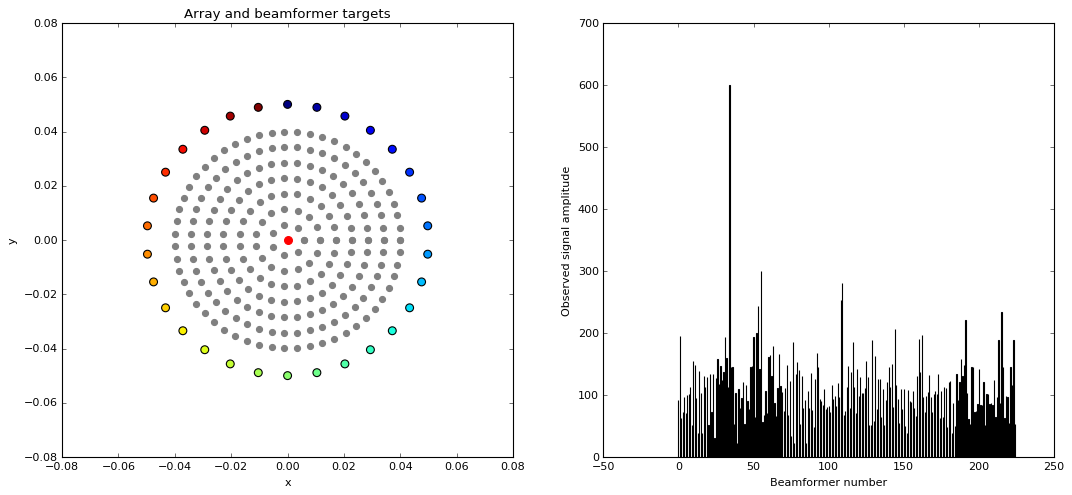

In [45]:
f0 = fMix + 150e6
f1 = fMix + 200e6
f2 = fMix + 210e6
S0 = Signal(1.0, f0, 0.0, 0.0, 0)
S1 = Signal(1.0, f1, 0.02, m.pi/2, 0)
S2 = Signal(1.0, f2, 0.02, 3*m.pi/2, 0)

ReceivedSignal =  Array.ReceiveSignals([S0, S1, S2], t, fMix, sampling_rate, tmax)
Set0.DistributeSignal(ReceivedSignal)
Set0.CollectAbsoluteMaxima()

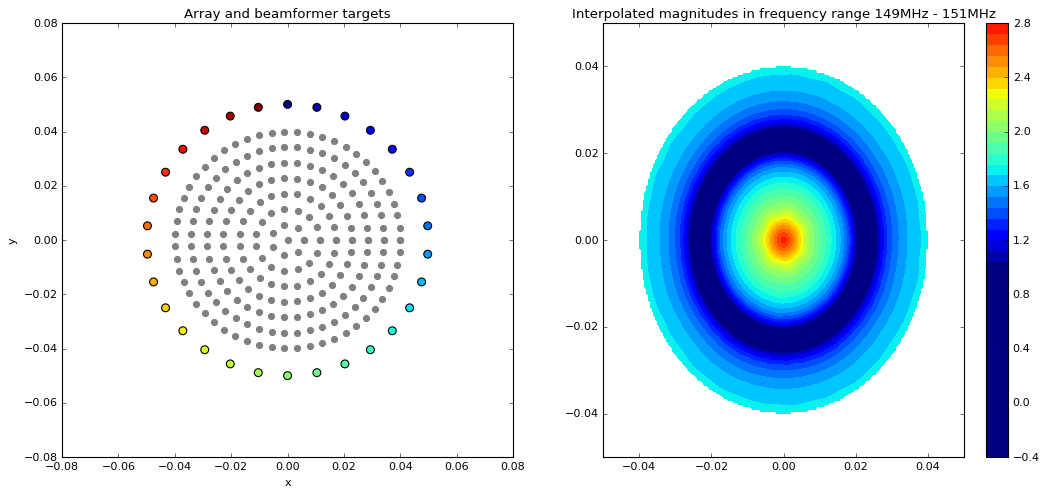

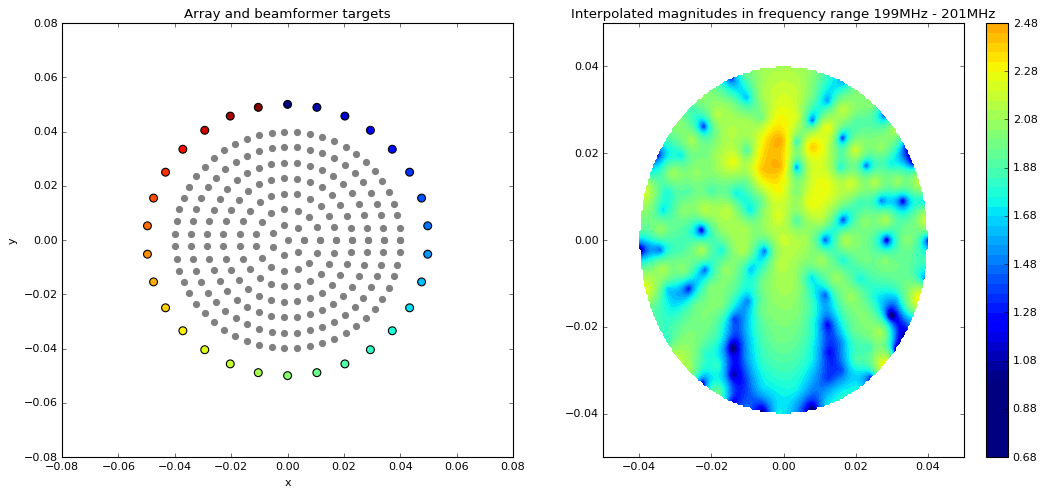

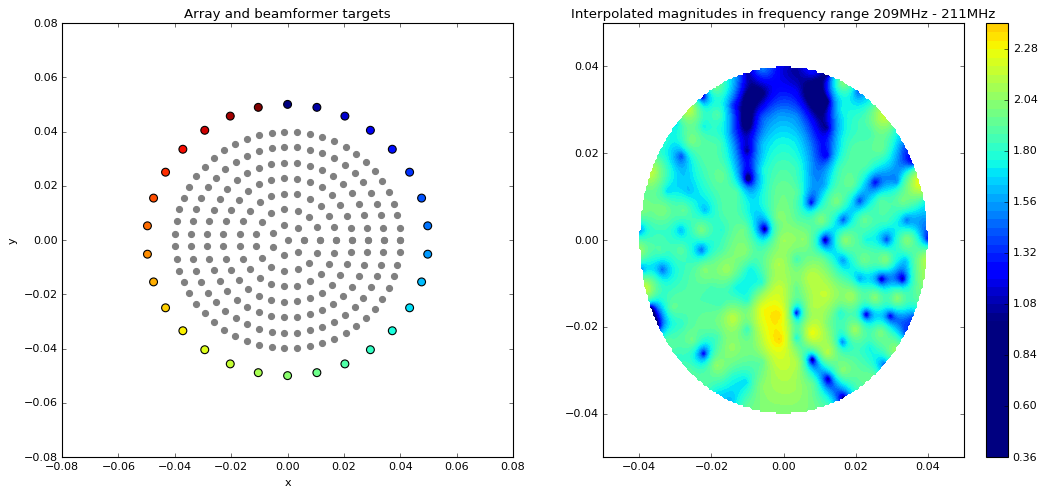

In [47]:
r, phi, M = Set0.Magnitude([149e6, 151e6])
Set0.Plotter()
MagnitudePlot(r, phi, M, 200, [149e6, 151e6])

r, phi, M = Set0.Magnitude([199e6, 201e6])
Set0.Plotter()
MagnitudePlot(r, phi, M, 200, [199e6, 201e6])

r, phi, M = Set0.Magnitude([209e6, 211e6])
Set0.Plotter()
MagnitudePlot(r, phi, M, 200, [209e6, 211e6])

## Add noise to antennas

In [ ]:
from AntennaArray import *

def ReceivedSignalPlusNoiseAM(self, signal, t):
    receivedsignal0 = signal.TimeShiftedSignal(self.TimeDelay(signal), t)/self.DistanceToSource(signal)**2
    noise = np.random.randn(np.shape(t)[0])*1000
    receivedsignal1 = receivedsignal0 + noise
    return receivedsignal1

def ReceivedSignalsPlusNoise(self, signals, t):
        # Calculate signals as seen by antennas and pass them to the beamformers so not everyboday recalculates
        #print('Calculating signal as seen by antennas')
        NSignalBins = np.shape(t)[0]
        #np.shape(self.Antennas[0].ReceivedSignalAfterMixDown(signals[0], t))[0]
        #print("NSignalBins", NSignalBins)

        ReceivedSignals = []
        for i in range(self.NAntennas):
            s = np.zeros(NSignalBins)+1j*np.zeros(NSignalBins)
            for j in range(len(signals)):
                s += self.Antennas[i].ReceivedSignalPlusNoiseAM(signals[j], t)
            ReceivedSignals.append(s)
        #print('Done')
        return ReceivedSignals

#10^5 = noise/signal
#Antenna.ReceivedSignalAfterMixDown=ReceivedSignalAfterMixDown1
Antenna.ReceivedSignalPlusNoiseAM=ReceivedSignalPlusNoiseAM
AntennaArray.ReceivedSignalsPlusNoise = ReceivedSignalsPlusNoise

#Set0.threshold = 1.2*10**5
S0 = Signal(1.0, 25*10**9, 0.03, m.pi)
S0.MixDownSignal(24.5*10**9, t)

Array0 = AntennaArray(0.05, 30)
Set1 = SetOfBeamformers(4, 4, Array0, SR, NBins)

ReceivedSignals = Array0.ReceivedSignalsPlusNoise([S0], t)
Set1.DistributeSignal(ReceivedSignals)

r, phi, M = Set1.Magnitude([490e6, 510e6])
Set1.Plotter()
MagnitudePlot(r, phi, M, 200)

In [ ]:
Set1.threshold = 1000
Set1.FormerOverFreq()
Set1.CollectAbsoluteMaxima()


In [ ]:
Set1.Beamformers['9'].Plotter()

## Multiprocess

## Mark's plot

Marks plot was done for transmitting antennas.
The message is: amplitude for origin seen by beamformer looking at one spot

In [ ]:
Array0 = AntennaArray(0.05, 16)
B1 = Beamformer(0.03, 3/2*m.pi, Array0, SR, NBins)

In [ ]:
#c = Client()  #If no profile is given, use the default profile

#lv = c.load_balanced_view()
#print(c.ids)
class SignalMap:
    def __init__(self, NRings, NAngles1, Array):
        self.Array = Array
        self.Signals = {}
        self.ReceivedSignals = {}
        self.NSignals = 0
        self.Amplitude = {}
        self.origins = []
        
        
        
        self.Signals[str(self.NSignals)]=Signal(1.0, 25*10**9, 0.0, 0.0)
        self.Signals[str(self.NSignals)].MixDownSignal(24.5*10**9, t) 
        self.origins.append([0.0, 0.0])
                
        
        r = np.linspace(0, 5.0*(1-1/NRings), NRings)/100
           
        for i in range(NRings-1):
            
            nphi = (i+1)*NAngles1
            phi = np.linspace(0,2.0*np.pi*(1-1/nphi), nphi)
            
            for j in range(nphi):
                self.NSignals +=1
                self.Signals[str(self.NSignals)]=Signal(1.0, 25*10**9, r[i+1], phi[j])
                self.Signals[str(self.NSignals)].MixDownSignal(24.5*10**9, t)
                self.origins.append([r[i+1], phi[j]])

        
    def SendMapToAntennas(self):
        tasks = []
        
        for i in self.Signals.keys():
            
            #tasks.append(lv.map(Array.ReceiveSignals, [self.Signals[i]]))
            
            self.ReceivedSignals[i]= self.Array.ReceivedSignalsPlusNoise([self.Signals[i]], t)
            wsignal, formedsignal, [freqs, formedspectrum] = B1.PhaseShift(self.ReceivedSignals[i])
            self.Amplitude[i]= np.max(np.abs(formedspectrum))
        
        return tasks
    

SignalMap0 = SignalMap(8, 6, Array0)   
#tasks=SignalMap0.SendMapToAntennas()
print('done')


In [ ]:
tasks[0]

In [ ]:


def MagnitudePlot(self, n):
        Z = np.zeros(self.NSignals+1)
        r = np.copy(Z)
        phi = np.copy(Z)
        
               
        for i in self.Signals.keys():   
            # for surf plot

            r[int(i)], phi[int(i)] = self.Signals[i].r, self.Signals[i].phi
            Z[int(i)] = self.Amplitude[i]
            
        Z_interp = interpolate.Rbf(np.array(r*np.cos(phi)), np.array(r*np.sin(phi)), (Z), function='linear')
        x = np.linspace(-0.05, 0.05, n)
        y = np.linspace(-0.05, 0.05, n)
        X, Y = np.meshgrid(x, y)
        Z1 = Z_interp(X, Y)
        Z1[X**2+Y**2>0.045**2] = "nan"
        
        fig=plt.figure(figsize=(16, 7), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(121)
        plt.contourf(X, Y, 10*np.log10(Z1), 100)#, vmin=-8, vmax=8)
        plt.colorbar()
        plt.xlim([-0.05, 0.05])
        plt.ylim([-0.05, 0.05])
        
        r = np.array(self.origins).T[0]
        phi = np.array(self.origins).T[1]
        plt.scatter(r*np.cos(phi), r*np.sin(phi), marker='+', s=100, color="cyan")
        plt.scatter(B1.r*np.cos(B1.phi), B1.r*np.sin(B1.phi), marker='*', s=100, color="black")
            
        return 

SignalMap.MagnitudePlot = MagnitudePlot
SignalMap0.MagnitudePlot(200)